<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/02-bow%2Blr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline JAIIO: BoW+Regresión Logística

En esta notebook se presetan los experimentos sobre la estrategia de representación y técnica de aprendizaje *baseline* utilizada para las 50 JAIIO.

Para ello vamos a preprocesar los correos y aplicar:
- Bag of words,
- Regresión logística para quedarnos con los vectores de coeficientes como indicador de las _features_ importantes.


## Instalación y Carga de librerías y funciones útiles

### Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab

In [9]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget

### Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [10]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [11]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

### Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [12]:
import warnings
from os import path
warnings.filterwarnings("ignore")

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = 4

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/'
TRAIN_FILE = 'correos-train-80.csv'
TEST_FILE = 'correos-test-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()
train_df, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
train_df['Consulta'] = pd.Series(preprocesar_correos(train_df['Consulta']))
test_df['Consulta'] = pd.Series(preprocesar_correos(test_df['Consulta']))

# Cambio los integers por las etiquetas
train_df['clase'] = etiquetas[train_df['clase']]
test_df['clase'] = etiquetas[test_df['clase']]

# Las vuelvo a pasar a números 0-N para evitar conflictos con simpletransformers
# Este paso está fijo para estos experimentos
dict_clases_id = {'Otras Consultas': 0,
                            'Ingreso a la Universidad': 1,
                            'Boleto Universitario': 2,
                            'Requisitos de Ingreso': 3}

train_df['clase'].replace(dict_clases_id, inplace=True)
test_df['clase'].replace(dict_clases_id, inplace=True)

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df.clase.unique()), train_df.clase.unique()))


El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 4 clases: [0 1 2 3].


## Regresión Logística

Se carga en memoria la función _grid_search_por_estrategia_representacion_ que va a iterar ajustando los hiperparámetros para las técnica de __LR__ y _representacion_documentos_ con la generación de las diferentes representaciones:

In [17]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import gridsearch_por_estrategia_representacion, representacion_documentos

Se define el espacio de búsqueda para el ajuste de hiperparámetros del modelo:

In [14]:
# Defino una lista con los esquemas de representación
estrategias_representacion = ['BOW', 'TFIDF', '3-4-NGRAM-CHARS', '1-2-NGRAM-WORDS']
modelo = 'LR'
# Defino los parámetros para GridSearchCV
params_lr = {'LR__C': [0.001, 0.01, 0.1, 1, 10, 100]}

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [15]:
for estrategia in estrategias_representacion:
  # Llamo a la función que realiza el gridsearch por estrategia  
  gridsearch_por_estrategia_representacion(train_df, test_df, estrategia, modelo, params_lr, 'drive')

Estrategia de representación: BOW
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.7s finished


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Estrategia de representación: BOW
Parámetros: {'LR__C': 1, 'clasificador': 'LR', 'estrategia': 'BOW', 'accuracy': 0.865, 'precision': 0.8528951386844984, 'recall': 0.8220648863659905, 'f1_score': 0.833183514560302}
Accuracy Test-Set: 0.865
Estrategia de representación: TFIDF
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.7s finished


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Estrategia de representación: TFIDF
Parámetros: {'LR__C': 1, 'clasificador': 'LR', 'estrategia': 'TFIDF', 'accuracy': 0.87, 'precision': 0.8479142635314997, 'recall': 0.8445819262880938, 'f1_score': 0.8461242425953697}
Accuracy Test-Set: 0.87
Estrategia de representación: 3-4-NGRAM-CHARS
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   45.7s finished


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Estrategia de representación: 3-4-NGRAM-CHARS
Parámetros: {'LR__C': 10, 'clasificador': 'LR', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.87, 'precision': 0.8575891408169889, 'recall': 0.8424402825830243, 'f1_score': 0.8475238514963805}
Accuracy Test-Set: 0.87
Estrategia de representación: 1-2-NGRAM-WORDS
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   42.9s finished


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Estrategia de representación: 1-2-NGRAM-WORDS
Parámetros: {'LR__C': 1, 'clasificador': 'LR', 'estrategia': '1-2-NGRAM-WORDS', 'accuracy': 0.86, 'precision': 0.8409972499638154, 'recall': 0.8189003294039652, 'f1_score': 0.827086477283026}
Accuracy Test-Set: 0.86


### Vector de coeficientes

Pongo en memoria la función para representación de documentos del repositorio del proyecto:

In [18]:
from funciones_dataset import consolidar_df
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Genero la representación de documentos
correos_train_vec, correos_test_vec = representacion_documentos(train_df['Consulta'], test_df['Consulta'], 'TFIDF', None)

# Separo en x e y - train y test- (además consolido feature estáticas con dinámicas)
x_train, y_train = consolidar_df(train_df, correos_train_vec, 'Consulta', 'clase')
x_test, y_test = consolidar_df(test_df, correos_test_vec, 'Consulta', 'clase')
  
# Escalado de datos: Se probó scale y MinMaxScaler y dió mejores resultados el último
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

# Instancio y entreno el modelo
clf = LogisticRegression(C=1)
clf.fit(x_train_scaled, y_train)

# Se realizan las predicciones sobre el conjunto de validación
y_predictions = clf.predict(x_test_scaled) 

# Calculo el accuracy sobre test
acc_test = accuracy_score(y_test, y_predictions)

print('Accuracy Test-Set: {}' . format(acc_test))

Accuracy Test-Set: 0.87


Ahora se retornan los vectores de coeficientes para las clases:

In [32]:
clf.coef_

array([ 0.25950884, -0.15211498, -0.19884215, ..., -0.02337214,
       -0.16211122,  0.10163046])

In [26]:
!pip install mglearn

     |████████████████████████████████| 542kB 7.3MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582638 sha256=cd2ba3c4c0f9ed0b86eddc760777f238f295a6f9ba37ed0bbb5bb5c8267b99a8
  Stored in directory: /root/.cache/pip/wheels/eb/a6/ea/a6a3716233fa62fc561259b5cb1e28f79e9ff3592c0adac5f0
Successfully built mglearn


Boleto Universitario


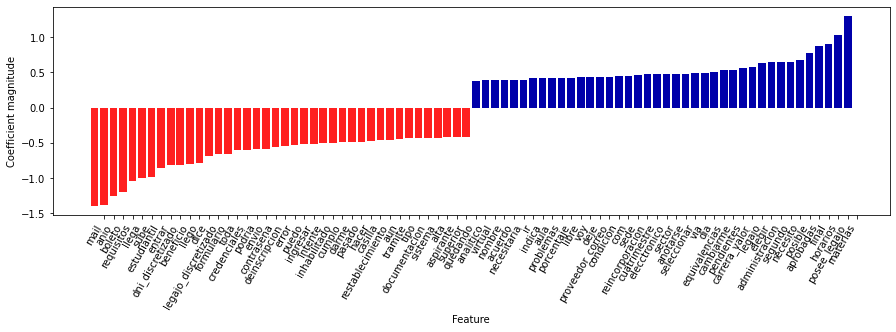

In [37]:
import mglearn

mglearn.tools.visualize_coefficients(clf.coef_[0], x_train.columns, n_top_features=40)
print(etiquetas[0])

Index(['%', '02', '04', '05', '06', '06/08', '0855', '09/08', '1', '10',
       ...
       'volver', 'volvi', 'voy', 'vuelta', 'vuelva', 'vuelvo', 'web', 'wep',
       'xq', 'yamila'],
      dtype='object', length=2021)

# Referencias
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05